# AlexNet Implementation

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import skimage
import skimage.transform
import skimage.io

### Prepare CIFAR-10 dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
cifar_trainset = datasets.CIFAR10(root='/Users/jaidevmirchandani/Documents/COGS181', train=True, download=True, transform=transform)

0it [00:00, ?it/s]

170500096it [00:09, 18505222.50it/s]                               


In [ ]:
cifar_testset = datasets.CIFAR10(root='/Users/jaidevmirchandani/Documents/COGS181', train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=6,shuffle=True, num_workers=2)

In [ ]:
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=6,shuffle=False, num_workers=2)

In [ ]:
classes = cifar_trainset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


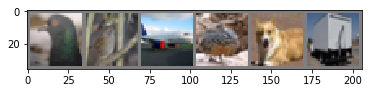

 bird  bird airplane  bird   dog truck


In [ ]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

### Choose a device

In [ ]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


### Build AlexNet Architecture

#### 1. Max Pooling, ReLU activation function, Stochastic Gradient Descent optimization method

In [ ]:
class AlexNet1(nn.Module):
    
    def __init__(self):
        super(AlexNet1, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.relu(self.convolution1(x))
        
        #Max Pooling 1
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.relu(self.convolution2(output))
        
        #Max Pooling 2
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.relu(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.relu(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.relu(self.convolution5(output))
        
        #Max Pooling 3
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet1 = AlexNet1()     # Create the network instance.
alexnet1.to(device)  # Move the network parameters to the specified device.

AlexNet1(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet1(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.302
[epoch: 0, i:   199] avg mini-batch loss: 2.302
[epoch: 0, i:   299] avg mini-batch loss: 2.304
[epoch: 0, i:   399] avg mini-batch loss: 2.303
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 0, i:   599] avg mini-batch loss: 2.302
[epoch: 0, i:   699] avg mini-batch loss: 2.302
[epoch: 0, i:   799] avg mini-batch loss: 2.301
[epoch: 0, i:   899] avg mini-batch loss: 2.300
[epoch: 0, i:   999] avg mini-batch loss: 2.306
[epoch: 0, i:  1099] avg mini-batch loss: 2.297
[epoch: 0, i:  1199] avg mini-batch loss: 2.302
[epoch: 0, i:  1299] avg mini-batch loss: 2.304
[epoch: 0, i:  1399] avg mini-batch loss: 2.302
[epoch: 0, i:  1499] avg mini-batch loss: 2.302
[epoch: 0, i:  1599] avg mini-batch loss: 2.301
[epoch: 0, i:  1699] avg mini-batch loss: 2.300
[epoch: 0, i:  1799] avg mini-batch loss: 2.300
[epoch: 0, i:  1899] avg mini-batch loss: 2.299
[epoch: 0, i:  1999] avg mini-batch loss: 2.299
[epoch: 0, i:  2099] avg mini-batch loss

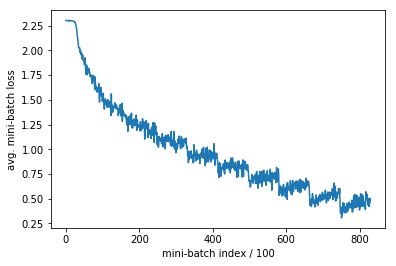

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

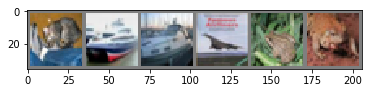

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship airplane airplane


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet1(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet1(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 80 %
Accuracy of automobile : 74 %
Accuracy of  bird : 52 %
Accuracy of   cat : 43 %
Accuracy of  deer : 62 %
Accuracy of   dog : 45 %
Accuracy of  frog : 65 %
Accuracy of horse : 80 %
Accuracy of  ship : 78 %
Accuracy of truck : 76 %


#### 2. Max Pooling, Sigmoid activation function, Stochastic Gradient Descent optimization method

In [ ]:
class AlexNet2(nn.Module):
    
    def __init__(self):
        super(AlexNet2, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.sigmoid(self.convolution1(x))
        
        #Max Pooling 1
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.sigmoid(self.convolution2(output))
        
        #Max Pooling 2
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.sigmoid(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.sigmoid(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.sigmoid(self.convolution5(output))
        
        #Max Pooling 3
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet2 = AlexNet2()     # Create the network instance.
alexnet2.to(device)  # Move the network parameters to the specified device.

AlexNet2(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet2(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch: 0, i:    99] avg mini-batch loss: 2.331
[epoch: 0, i:   199] avg mini-batch loss: 2.345
[epoch: 0, i:   299] avg mini-batch loss: 2.323
[epoch: 0, i:   399] avg mini-batch loss: 2.326
[epoch: 0, i:   499] avg mini-batch loss: 2.324
[epoch: 0, i:   599] avg mini-batch loss: 2.331
[epoch: 0, i:   699] avg mini-batch loss: 2.337
[epoch: 0, i:   799] avg mini-batch loss: 2.339
[epoch: 0, i:   899] avg mini-batch loss: 2.320
[epoch: 0, i:   999] avg mini-batch loss: 2.324
[epoch: 0, i:  1099] avg mini-batch loss: 2.329
[epoch: 0, i:  1199] avg mini-batch loss: 2.331
[epoch: 0, i:  1299] avg mini-batch loss: 2.327
[epoch: 0, i:  1399] avg mini-batch loss: 2.328
[epoch: 0, i:  1499] avg mini-batch loss: 2.332
[epoch: 0, i:  1599] avg mini-batch loss: 2.331
[epoch: 0, i:  1699] avg mini-batch loss: 2.311
[epoch: 0, i:  1799] avg mini-batch loss: 2.328
[epoch: 0, i:  1899] avg mini-batch loss: 2.317
[epoch: 0, i:  1999] avg mini-batch loss: 2.321
[epoch: 0, i:  2099] avg mini-batch loss

#### 3. Average Pooling, ReLU activation function, Stochastic Gradient Descent optimization method

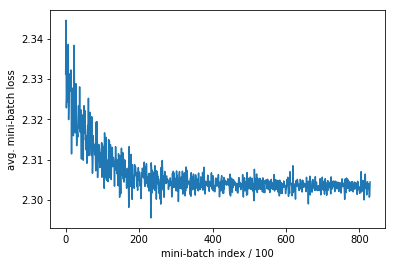

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

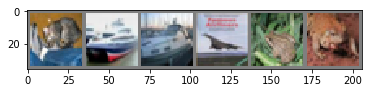

GroundTruth:    cat  ship  ship airplane
Predicted:  truck truck truck truck


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet2(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck : 100 %


#### 3. Average Pooling, ReLU activation function, Stochastic Gradient Descent optimization method

In [ ]:
class AlexNet3(nn.Module):
    
    def __init__(self):
        super(AlexNet3, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.relu(self.convolution1(x))
        
        #Max Pooling 1
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.relu(self.convolution2(output))
        
        #Max Pooling 2
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.relu(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.relu(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.relu(self.convolution5(output))
        
        #Max Pooling 3
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet3 = AlexNet3()     # Create the network instance.
alexnet3.to(device)  # Move the network parameters to the specified device.

AlexNet3(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet3.parameters(), lr=0.001, momentum=0.9)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet3(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.305
[epoch: 0, i:   199] avg mini-batch loss: 2.302
[epoch: 0, i:   299] avg mini-batch loss: 2.305
[epoch: 0, i:   399] avg mini-batch loss: 2.302
[epoch: 0, i:   499] avg mini-batch loss: 2.304
[epoch: 0, i:   599] avg mini-batch loss: 2.303
[epoch: 0, i:   699] avg mini-batch loss: 2.301
[epoch: 0, i:   799] avg mini-batch loss: 2.303
[epoch: 0, i:   899] avg mini-batch loss: 2.302
[epoch: 0, i:   999] avg mini-batch loss: 2.306
[epoch: 0, i:  1099] avg mini-batch loss: 2.303
[epoch: 0, i:  1199] avg mini-batch loss: 2.301
[epoch: 0, i:  1299] avg mini-batch loss: 2.303
[epoch: 0, i:  1399] avg mini-batch loss: 2.300
[epoch: 0, i:  1499] avg mini-batch loss: 2.305
[epoch: 0, i:  1599] avg mini-batch loss: 2.305
[epoch: 0, i:  1699] avg mini-batch loss: 2.304
[epoch: 0, i:  1799] avg mini-batch loss: 2.303
[epoch: 0, i:  1899] avg mini-batch loss: 2.303
[epoch: 0, i:  1999] avg mini-batch loss: 2.303
[epoch: 0, i:  2099] avg mini-batch loss

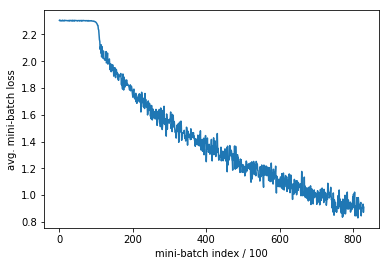

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

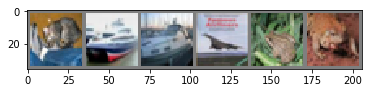

GroundTruth:    cat  ship  ship airplane
Predicted:  airplane  ship  ship airplane


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet3(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet3(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 72 %
Accuracy of automobile : 77 %
Accuracy of  bird : 50 %
Accuracy of   cat : 33 %
Accuracy of  deer : 65 %
Accuracy of   dog : 40 %
Accuracy of  frog : 75 %
Accuracy of horse : 72 %
Accuracy of  ship : 85 %
Accuracy of truck : 65 %


#### 4. Average Pooling, Sigmoid activation function, Stochastic Gradient Descent optimization method

In [ ]:
class AlexNet4(nn.Module):
    
    def __init__(self):
        super(AlexNet4, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.sigmoid(self.convolution1(x))
        
        #Max Pooling 1
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.sigmoid(self.convolution2(output))
        
        #Max Pooling 2
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.sigmoid(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.sigmoid(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.sigmoid(self.convolution5(output))
        
        #Max Pooling 3
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet4 = AlexNet4()     # Create the network instance.
alexnet4.to(device)  # Move the network parameters to the specified device.

AlexNet4(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet4.parameters(), lr=0.001, momentum=0.9)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet4(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch: 0, i:    99] avg mini-batch loss: 2.322
[epoch: 0, i:   199] avg mini-batch loss: 2.315
[epoch: 0, i:   299] avg mini-batch loss: 2.343
[epoch: 0, i:   399] avg mini-batch loss: 2.336
[epoch: 0, i:   499] avg mini-batch loss: 2.327
[epoch: 0, i:   599] avg mini-batch loss: 2.335
[epoch: 0, i:   699] avg mini-batch loss: 2.338
[epoch: 0, i:   799] avg mini-batch loss: 2.328
[epoch: 0, i:   899] avg mini-batch loss: 2.331
[epoch: 0, i:   999] avg mini-batch loss: 2.313
[epoch: 0, i:  1099] avg mini-batch loss: 2.340
[epoch: 0, i:  1199] avg mini-batch loss: 2.333
[epoch: 0, i:  1299] avg mini-batch loss: 2.325
[epoch: 0, i:  1399] avg mini-batch loss: 2.329
[epoch: 0, i:  1499] avg mini-batch loss: 2.325
[epoch: 0, i:  1599] avg mini-batch loss: 2.334
[epoch: 0, i:  1699] avg mini-batch loss: 2.331
[epoch: 0, i:  1799] avg mini-batch loss: 2.322
[epoch: 0, i:  1899] avg mini-batch loss: 2.318
[epoch: 0, i:  1999] avg mini-batch loss: 2.328
[epoch: 0, i:  2099] avg mini-batch loss

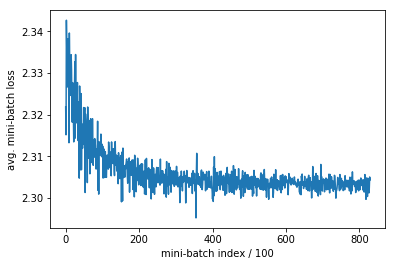

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

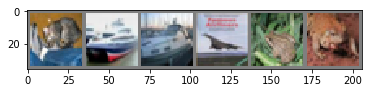

GroundTruth:    cat  ship  ship airplane
Predicted:   frog  frog  frog  frog


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet4(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet4(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 100 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### 5. Max Pooling, ReLU activation function, Adam optimization method

In [ ]:
class AlexNet5(nn.Module):
    
    def __init__(self):
        super(AlexNet5, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.relu(self.convolution1(x))
        
        #Max Pooling 1
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.relu(self.convolution2(output))
        
        #Max Pooling 2
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.relu(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.relu(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.relu(self.convolution5(output))
        
        #Max Pooling 3
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet5 = AlexNet5()     # Create the network instance.
alexnet5.to(device)  # Move the network parameters to the specified device.

AlexNet5(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(alexnet5.parameters(), lr=0.001)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet5(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.283
[epoch: 0, i:   199] avg mini-batch loss: 2.166
[epoch: 0, i:   299] avg mini-batch loss: 2.096
[epoch: 0, i:   399] avg mini-batch loss: 2.072
[epoch: 0, i:   499] avg mini-batch loss: 2.112
[epoch: 0, i:   599] avg mini-batch loss: 2.030
[epoch: 0, i:   699] avg mini-batch loss: 2.058
[epoch: 0, i:   799] avg mini-batch loss: 2.001
[epoch: 0, i:   899] avg mini-batch loss: 1.989
[epoch: 0, i:   999] avg mini-batch loss: 1.973
[epoch: 0, i:  1099] avg mini-batch loss: 2.008
[epoch: 0, i:  1199] avg mini-batch loss: 2.018
[epoch: 0, i:  1299] avg mini-batch loss: 1.943
[epoch: 0, i:  1399] avg mini-batch loss: 1.941
[epoch: 0, i:  1499] avg mini-batch loss: 1.888
[epoch: 0, i:  1599] avg mini-batch loss: 1.899
[epoch: 0, i:  1699] avg mini-batch loss: 1.923
[epoch: 0, i:  1799] avg mini-batch loss: 1.899
[epoch: 0, i:  1899] avg mini-batch loss: 1.903
[epoch: 0, i:  1999] avg mini-batch loss: 1.892
[epoch: 0, i:  2099] avg mini-batch loss

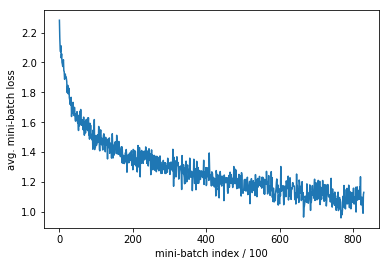

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

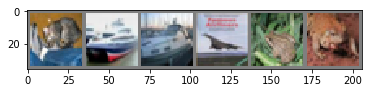

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet5(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet5(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 55 %
Accuracy of automobile : 61 %
Accuracy of  bird : 41 %
Accuracy of   cat : 59 %
Accuracy of  deer : 45 %
Accuracy of   dog : 37 %
Accuracy of  frog : 67 %
Accuracy of horse : 71 %
Accuracy of  ship : 84 %
Accuracy of truck : 61 %


#### 6. Max Pooling, Sigmoid activation function, Adam optimization method

In [ ]:
class AlexNet6(nn.Module):
    
    def __init__(self):
        super(AlexNet6, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.sigmoid(self.convolution1(x))
        
        #Max Pooling 1
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.sigmoid(self.convolution2(output))
        
        #Max Pooling 2
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.sigmoid(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.sigmoid(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.sigmoid(self.convolution5(output))
        
        #Max Pooling 3
        output = F.max_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet6 = AlexNet6()     # Create the network instance.
alexnet6.to(device)  # Move the network parameters to the specified device.

AlexNet6(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(alexnet6.parameters(), lr=0.001)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet6(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch: 0, i:    99] avg mini-batch loss: 2.334
[epoch: 0, i:   199] avg mini-batch loss: 2.342
[epoch: 0, i:   299] avg mini-batch loss: 2.350
[epoch: 0, i:   399] avg mini-batch loss: 2.333
[epoch: 0, i:   499] avg mini-batch loss: 2.343
[epoch: 0, i:   599] avg mini-batch loss: 2.325
[epoch: 0, i:   699] avg mini-batch loss: 2.353
[epoch: 0, i:   799] avg mini-batch loss: 2.345
[epoch: 0, i:   899] avg mini-batch loss: 2.331
[epoch: 0, i:   999] avg mini-batch loss: 2.340
[epoch: 0, i:  1099] avg mini-batch loss: 2.336
[epoch: 0, i:  1199] avg mini-batch loss: 2.369
[epoch: 0, i:  1299] avg mini-batch loss: 2.343
[epoch: 0, i:  1399] avg mini-batch loss: 2.334
[epoch: 0, i:  1499] avg mini-batch loss: 2.346
[epoch: 0, i:  1599] avg mini-batch loss: 2.339
[epoch: 0, i:  1699] avg mini-batch loss: 2.355
[epoch: 0, i:  1799] avg mini-batch loss: 2.332
[epoch: 0, i:  1899] avg mini-batch loss: 2.348
[epoch: 0, i:  1999] avg mini-batch loss: 2.321
[epoch: 0, i:  2099] avg mini-batch loss

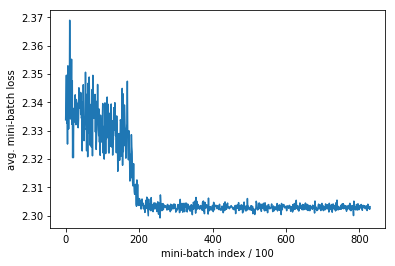

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

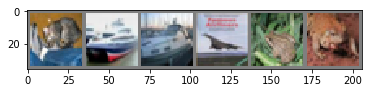

GroundTruth:    cat  ship  ship airplane
Predicted:  truck truck truck truck


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet6(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet6(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet6(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck : 100 %


#### 7. Average Pooling, ReLU activation function, Adam optimization method

In [ ]:
class AlexNet7(nn.Module):
    
    def __init__(self):
        super(AlexNet7, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.relu(self.convolution1(x))
        
        #Max Pooling 1
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.relu(self.convolution2(output))
        
        #Max Pooling 2
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.relu(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.relu(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.relu(self.convolution5(output))
        
        #Max Pooling 3
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet7 = AlexNet7()     # Create the network instance.
alexnet7.to(device)  # Move the network parameters to the specified device.

AlexNet7(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(alexnet7.parameters(), lr=0.001)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet7(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.273
[epoch: 0, i:   199] avg mini-batch loss: 2.225
[epoch: 0, i:   299] avg mini-batch loss: 2.096
[epoch: 0, i:   399] avg mini-batch loss: 2.074
[epoch: 0, i:   499] avg mini-batch loss: 2.152
[epoch: 0, i:   599] avg mini-batch loss: 2.078
[epoch: 0, i:   699] avg mini-batch loss: 2.027
[epoch: 0, i:   799] avg mini-batch loss: 2.059
[epoch: 0, i:   899] avg mini-batch loss: 2.068
[epoch: 0, i:   999] avg mini-batch loss: 2.013
[epoch: 0, i:  1099] avg mini-batch loss: 1.988
[epoch: 0, i:  1199] avg mini-batch loss: 1.940
[epoch: 0, i:  1299] avg mini-batch loss: 1.910
[epoch: 0, i:  1399] avg mini-batch loss: 1.919
[epoch: 0, i:  1499] avg mini-batch loss: 1.853
[epoch: 0, i:  1599] avg mini-batch loss: 1.842
[epoch: 0, i:  1699] avg mini-batch loss: 1.838
[epoch: 0, i:  1799] avg mini-batch loss: 1.829
[epoch: 0, i:  1899] avg mini-batch loss: 1.905
[epoch: 0, i:  1999] avg mini-batch loss: 1.842
[epoch: 0, i:  2099] avg mini-batch loss

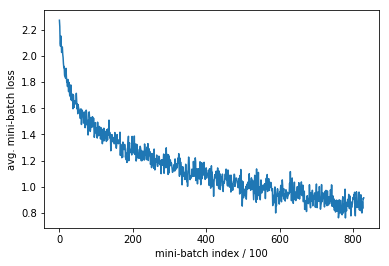

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

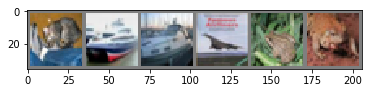

GroundTruth:    cat  ship  ship airplane
Predicted:    cat automobile  ship airplane


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet7(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet7(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet7(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 73 %
Accuracy of automobile : 79 %
Accuracy of  bird : 49 %
Accuracy of   cat : 51 %
Accuracy of  deer : 46 %
Accuracy of   dog : 48 %
Accuracy of  frog : 72 %
Accuracy of horse : 67 %
Accuracy of  ship : 66 %
Accuracy of truck : 65 %


#### 8. Average Pooling, Sigmoid activation function, Adam optimization method

In [ ]:
class AlexNet8(nn.Module):
    
    def __init__(self):
        super(AlexNet8, self).__init__()
        
        #3 input channels, 96 output channels, 11x11 kernel size
        self.convolution1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=5)
        
        #96 input channels, 192 output channels, 5x5 kernel size
        self.convolution2 = nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2)
        
        #192 input channels, 384 output channels, 3x3 kernel size
        self.convolution3 = nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,padding=1)
        
        #384 input channels, 256 output channels, 3x3 kernel size
        self.convolution4 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        
        #256 input channels, 256 output channels, 3x3 kernel size
        self.convolution5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        
        #256 inputs
        self.fullyconnected1 = nn.Linear(in_features=256,out_features=10)
        
    
    def forward(self,x):
        
        #ReLU non-linearity in convolution 1
        output = F.sigmoid(self.convolution1(x))
        
        #Max Pooling 1
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 2
        output = F.sigmoid(self.convolution2(output))
        
        #Max Pooling 2
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        #ReLU non-linearity in convolution 3
        output = F.sigmoid(self.convolution3(output))
        
        #ReLU non-linearity in convolution 4
        output = F.sigmoid(self.convolution4(output))
        
        #ReLU non-linearity in convolution 5
        output = F.sigmoid(self.convolution5(output))
        
        #Max Pooling 3
        output = F.avg_pool2d(output,kernel_size=2,stride=2)
        
        output = output.view(output.size(0), -1)
        
        output = self.fullyconnected1(output)
        
        return output
    
alexnet8 = AlexNet8()     # Create the network instance.
alexnet8.to(device)  # Move the network parameters to the specified device.

AlexNet8(
  (convolution1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (convolution2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (convolution3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyconnected1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(alexnet8.parameters(), lr=0.001)

In [ ]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet8(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch: 0, i:    99] avg mini-batch loss: 2.345
[epoch: 0, i:   199] avg mini-batch loss: 2.336
[epoch: 0, i:   299] avg mini-batch loss: 2.353
[epoch: 0, i:   399] avg mini-batch loss: 2.342
[epoch: 0, i:   499] avg mini-batch loss: 2.344
[epoch: 0, i:   599] avg mini-batch loss: 2.334
[epoch: 0, i:   699] avg mini-batch loss: 2.331
[epoch: 0, i:   799] avg mini-batch loss: 2.355
[epoch: 0, i:   899] avg mini-batch loss: 2.344
[epoch: 0, i:   999] avg mini-batch loss: 2.340
[epoch: 0, i:  1099] avg mini-batch loss: 2.353
[epoch: 0, i:  1199] avg mini-batch loss: 2.342
[epoch: 0, i:  1299] avg mini-batch loss: 2.347
[epoch: 0, i:  1399] avg mini-batch loss: 2.339
[epoch: 0, i:  1499] avg mini-batch loss: 2.338
[epoch: 0, i:  1599] avg mini-batch loss: 2.313
[epoch: 0, i:  1699] avg mini-batch loss: 2.324
[epoch: 0, i:  1799] avg mini-batch loss: 2.333
[epoch: 0, i:  1899] avg mini-batch loss: 2.349
[epoch: 0, i:  1999] avg mini-batch loss: 2.340
[epoch: 0, i:  2099] avg mini-batch loss

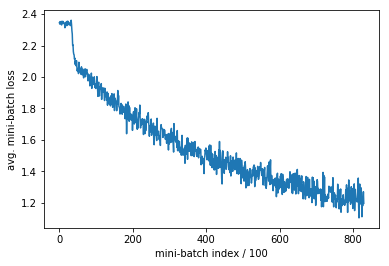

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

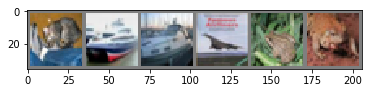

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = alexnet8(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet8(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 55 %


In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet8(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of airplane : 58 %
Accuracy of automobile : 71 %
Accuracy of  bird : 41 %
Accuracy of   cat : 27 %
Accuracy of  deer : 42 %
Accuracy of   dog : 47 %
Accuracy of  frog : 62 %
Accuracy of horse : 68 %
Accuracy of  ship : 78 %
Accuracy of truck : 55 %
